In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Humidity_adjustments/files/dest_*_relative_humidity_adjusted.nc')[0]
    data = eua.CDMDataset(file).to_dataframe()
    daydata = data[data.time.dt.hour > 6][data.time.dt.hour <= 18]
    nightdata = data[data.time.dt.hour <= 6].append(data[data.time.dt.hour > 18])
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'relative_humidity',
                    'optional':['humidity_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/hur/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/hur/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    return daydata, nightdata, daycdsdata, nightcdsdata

In [3]:
def plt_adj(cdata, adata, plev, station, time, adj, save):
    cdata = cdata[cdata.plev == plev*100]
    adata = adata[adata.plev == plev*100]
    fig, ax = plt.subplots()
    ax.scatter(cdata['time'], cdata.humidity_bias_estimate, label='CDS', s=50)
    ax.scatter(adata['time'], adata.hur_bias_estimate, label='Calc', s=20)

    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Humidity '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Humidity_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

In [4]:
# DOWNLOAD DATA FROM CDS:
home = os.getcwd()
%run gethum.py # downloading just: ['0-20001-0-11035', '0-20001-0-10393', '0-20001-0-70219', '0-20000-0-91413', '0-20000-0-35229', '0-20000-0-68994']
os.chdir(home)

Humidity_adjustments/files


In [5]:
files = glob.glob('Humidity_adjustments/files/downloaded/*/*72357*relative_humidity.nc')
display(files)

['Humidity_adjustments/files/downloaded/downloaded_72357/dest_0-20000-0-72357_relative_humidity.nc']

In [6]:
# RUN ADJUSTMENTS
import subprocess
for i in files:
    exc = ['./raso_adj_cdm_v1.py', '-f', './'+i, '--humidity', '--verbose']
    list_files = subprocess.run(exc)


2021-07-01 13:28:56,385 INFO Welcome to the CDS
2021-07-01 13:28:56,385 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-01 13:28:56,639 INFO Request is completed
2021-07-01 13:28:56,640 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138190.0704494-16300-4-ebb0fa48-b6a4-4865-b241-6a98472d6bec.zip to download.zip (21.1M)
2021-07-01 13:29:04,568 INFO Download rate 2.7M/s   
2021-07-01 13:29:04,846 INFO Reading Profile on slice(None, None, None)


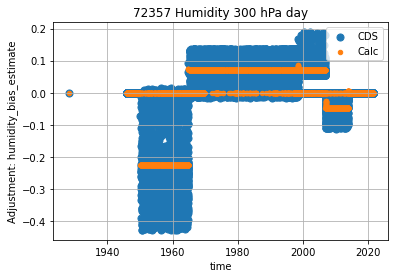

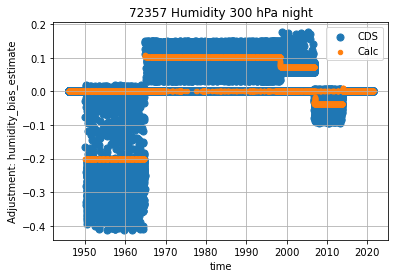

In [7]:
station = '72357'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 300, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 300, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

In [8]:
# station = '91413'
# dd, nd, dcd, ncd = get_adj(station)

# plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

2021-07-01 13:29:09,729 INFO Reading Profile on slice(None, None, None)
2021-07-01 13:29:11,879 INFO Welcome to the CDS
2021-07-01 13:29:11,879 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-07-01 13:29:12,054 INFO Request is completed
2021-07-01 13:29:12,055 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1625138448.9778574-12234-15-605fab37-c465-48a5-b154-750282c953fb.zip to download.zip (17.8M)
2021-07-01 13:29:15,363 INFO Download rate 5.4M/s   
2021-07-01 13:29:15,515 INFO Reading Profile on slice(None, None, None)


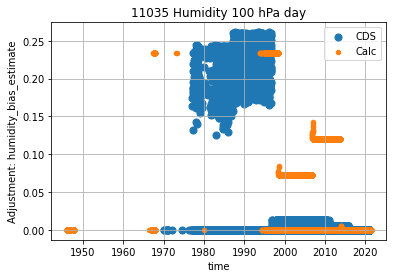

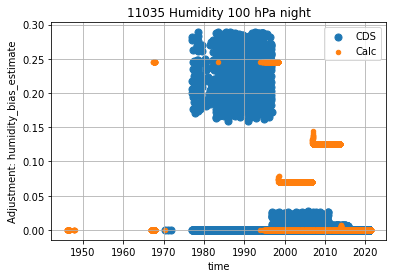

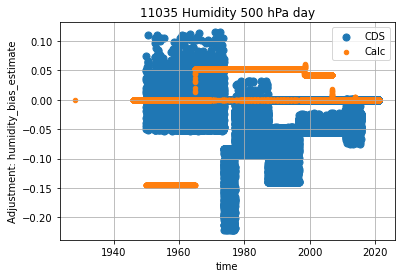

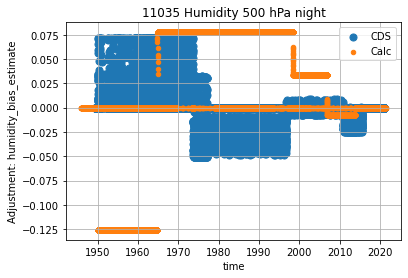

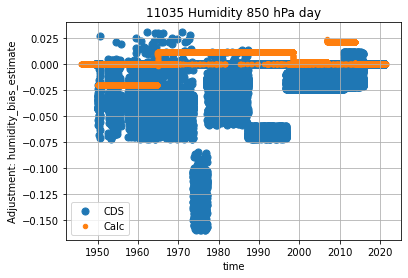

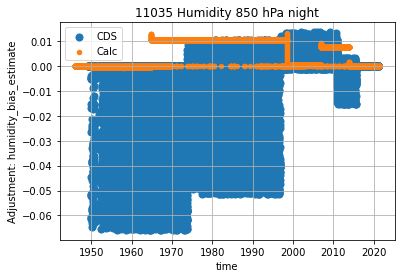

In [9]:
station = '11035'
dd, nd, dcd, ncd = get_adj(station)

plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)

In [10]:
# station = '10393'
# dd, nd, dcd, ncd = get_adj(station)

# plt_adj(dcd, dd, 100, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 100, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 500, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 500, station, 'night', 'humidity_bias_estimate', save=True)
# plt_adj(dcd, dd, 850, station, 'day', 'humidity_bias_estimate', save=True)
# plt_adj(ncd, nd, 850, station, 'night', 'humidity_bias_estimate', save=True)